<a href="https://colab.research.google.com/github/theoVasilas/Diplomatic_incident/blob/simulation/Fed_3_1_2_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [ ]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision

In [ ]:
from collections import OrderedDict, Counter
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_dataset, logging
from datasets.utils.logging import disable_progress_bar

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg, FedAdagrad
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cuda
Flower 1.13.1 / PyTorch 2.5.1+cu121


# Dataloader

In [ ]:
BATCH_SIZE = 32

In [ ]:
def load_datasets(partition_id: int, num_partitions: int):

    fds = FederatedDataset(
        dataset="mnist",
        partitioners={"train": num_partitions}
    )

    pytorch_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    partition = fds.load_partition(partition_id)
    # Divider : 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    #Apply Tranforms
    partition_train_test = partition_train_test.with_transform(apply_transforms)

    trainloader = DataLoader(partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True )
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)

    return trainloader, valloader, testloader

### Histogram of the dataset


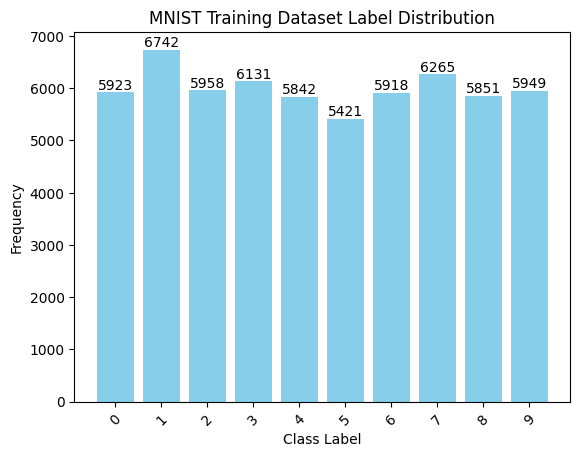

In [ ]:
# Load the MNIST dataset
mnist = load_dataset("mnist")

# Construct histogram for training labels
all_labels = mnist["train"]["label"]
all_label_counts = Counter(all_labels)

# Visualize the histogram
bar = plt.bar(all_label_counts.keys(), all_label_counts.values(), color="skyblue")
_ = plt.bar_label(bar)

# Plot formatting
plt.xticks(range(10), labels=[str(i) for i in range(10)], rotation=45)
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("MNIST Training Dataset Label Distribution")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


One Partition has 600 examples.
One Partition has 480 examples.
Entropy: 3.3129
Max Entropy (Uniform Distribution): 3.3219
Distribution Uniformity Ratio: 0.9973


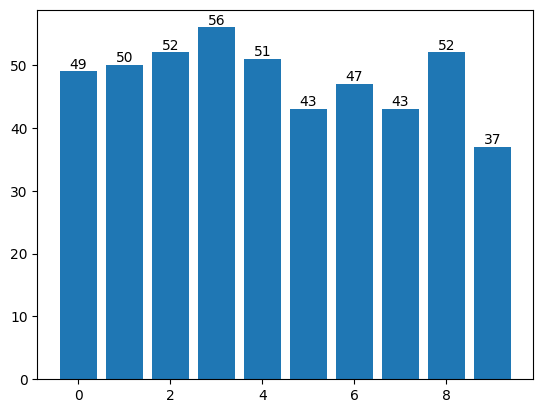

In [ ]:
num_partitions = 100  # Total number of participants
fds = FederatedDataset(
    dataset="mnist",
    partitioners={"train": num_partitions}
)

partition = fds.load_partition(0)
print(f"One Partition has {len(partition)} examples.")

# Divider : 80% train, 20% test
partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
train_size = len(partition_train_test["train"])
print(f"One Partition has {train_size} examples.")

all_labels = partition_train_test["train"]["label"]

label_counts = Counter(all_labels)

# Visualize the histogram
bar = plt.bar(label_counts.keys(), label_counts.values())
_ = plt.bar_label(bar)

total_count = sum(label_counts.values())

# Calculate proportions
proportions = [count / total_count for count in label_counts.values()]

# Calculate entropy
entropy = -sum(p * np.log2(p) for p in proportions)
max_entropy = np.log2(len(label_counts))  # Maximum entropy for uniform distribution

print(f"Entropy: {entropy:.4f}")
print(f"Max Entropy (Uniform Distribution): {max_entropy:.4f}")
print(f"Distribution Uniformity Ratio: {entropy / max_entropy:.4f}")

so the data is IID

# Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
net = Net()
num_parameters = sum(value.numel() for value in net.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 44426


# Train Test func


In [ ]:
def train(net, trainloader, optimizer, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()

        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0

    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)

            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# Federation

## set-get params


In [ ]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    # replace the parameters
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    """Extract model parameters as a list of NumPy arrays."""
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

## FlowerClient

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, pid, net, trainloader, valloader):
        self.pid = pid  # partition ID of a client
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.pid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.pid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)

        optim = torch.optim.SGD(self.net.parameters(), lr=0.01, momentum=0.9)
        train(self.net, self.trainloader,optim , epochs=local_epochs)
#============================================================================================
        # model_filename = f"federated_model_{server_round}.pth"
        # torch.save(net.state_dict(), model_filename)
        # print(f"Model saved as {model_filename}")
#============================================================================================
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):

        print(f"[Client {self.pid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)

        loss, accuracy = test(self.net, self.valloader)



        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:

    net = Net().to(DEVICE)

    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]

    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)

    # print(f"FlowerClient is created")
    return FlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

## Agregation Function

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
Agregation_history = []

def My_weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:

    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    losses = [num_examples * m.get("loss", 0.0) for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    accuracy = sum(accuracies) / sum(examples)
    loss = sum(losses) / sum(examples)

    # Save metrics to history
    Agregation_history.append({
        # "round": server_round,
        "loss": loss,
        "accuracy": accuracy
    })

    print(f"My_weighted_average -{accuracy} {loss} ")

    return {"accuracy": accuracy, "loss": loss}

## Server Evaluate metrics aggregation fn

In [ ]:
# The `evaluate` function will be called by Flower after every round
def evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:

    net = Net().to(DEVICE)

    _, _, testloader = load_datasets(0, NUM_CLIENTS)

    set_parameters(net, parameters)  # Update model with the latest parameters

    loss, accuracy = test(net, testloader)

    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")

    return loss, {"server_round": server_round, "accuracy": accuracy, "loss": loss}

In [ ]:
evaluation_history = []

def My_evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:

    net = Net().to(DEVICE)
    print(f"DEVICE {DEVICE}")

    _, _, testloader = load_datasets(0, NUM_CLIENTS)

    set_parameters(net, parameters)  # Update model with the latest parameters

    loss, accuracy = test(net, testloader)

    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")

    # Save metrics to history
    evaluation_history.append({
        "round": server_round,
        "loss": loss,
        "accuracy": accuracy
    })

    model_filename = f"federated_model_{server_round}.pth"
    torch.save(net.state_dict(), model_filename)
    print(f"Model saved as {model_filename}")

    return loss, {"accuracy": accuracy}


## Server Fn Strategy

In [ ]:
def fit_config(server_round: int):
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": 1 ,
    }
    return config

In [ ]:
NUM_CLIENTS = 100

In [ ]:
NUM_ROUNDS = 40

In [ ]:
params = get_parameters(Net())

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit  = 1,
        fraction_evaluate = 1,
        min_fit_clients  =  5,
        min_evaluate_clients  = 2,
        min_available_clients = NUM_CLIENTS, # use all
        evaluate_fn = My_evaluate, # function used for validation dy server
        on_fit_config_fn  = fit_config,  # Pass the fit_config function
        # on_evaluate_config_fn,
        # accept_failures,
        initial_parameters  = ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn =  My_weighted_average,
        # inplace,
    )

    config = ServerConfig(num_rounds = NUM_ROUNDS)

    return ServerAppComponents(strategy=strategy, config = config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

## RUN


In [ ]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.5}}

run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=40, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters


DEVICE cuda


INFO :      initial parameters (loss, other metrics): 0.07218546485900879, {'accuracy': 0.0917}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.07218546485900879 / accuracy 0.0917
Model saved as federated_model_0.pth


(pid=7327) 2024-12-11 09:50:51.201846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=7327) 2024-12-11 09:50:51.234613: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=7327) 2024-12-11 09:50:51.245055: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=7327) 2024-12-11 09:50:53.120378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=7329) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=7

(ClientAppActor pid=7327) [Client 65, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=7327) [Client 95, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=7329) [Client 29, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 16, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 11, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 51, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 13, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 6x across cluster]
(Clien

INFO :      aggregate_fit: received 100 results and 0 failures


(ClientAppActor pid=7329) [Client 28, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 6x across cluster]


DEVICE cuda


INFO :      fit progress: (1, 0.07145380725860595, {'accuracy': 0.118}, 129.55694663699978)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.07145380725860595 / accuracy 0.118
Model saved as federated_model_1.pth
(ClientAppActor pid=7327) [Client 40] evaluate, config: {}
(ClientAppActor pid=7329) [Client 10] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 38] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 53] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 47] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 94] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 24] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 8] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 26] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 98] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 90] evaluate, 

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.12183333333333332 0.0 
(ClientAppActor pid=7329) [Client 2, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 34] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=7327) [Client 90, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 93, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 87, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 58, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 6, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 21, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 6x across cluster]
(

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (2, 0.07041890695095063, {'accuracy': 0.2786}, 332.81421218699984)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.07041890695095063 / accuracy 0.2786
Model saved as federated_model_2.pth
(ClientAppActor pid=7327) [Client 11] evaluate, config: {}
(ClientAppActor pid=7327) [Client 49, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 89] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 58] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 12] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 26] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 44] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 4] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 92] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 71] evaluate, config: {} [repeated 6x across cluster]
(Client

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.2718333333333332 0.0 
(ClientAppActor pid=7327) [Client 47, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 43] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=7327) [Client 95, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 38, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7329) [Client 39, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 0, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 22, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 76, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 6x across cluster]
(

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (3, 0.06789185602664947, {'accuracy': 0.3943}, 532.8302172449999)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.06789185602664947 / accuracy 0.3943
Model saved as federated_model_3.pth
(ClientAppActor pid=7327) [Client 5] evaluate, config: {}
(ClientAppActor pid=7327) [Client 87, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 35] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 32] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 54] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 81] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 39] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 13] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 30] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 60] evaluate, config: {} [repeated 6x across cluster]
(Client

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.3889999999999999 0.0 
(ClientAppActor pid=7327) [Client 11, round 4] fit, config: {'server_round': 4, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 92] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=7327) [Client 43, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 37, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 35, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 41, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 67, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 88, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 6x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (4, 0.05887367551326752, {'accuracy': 0.591}, 737.6428895629999)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.05887367551326752 / accuracy 0.591
Model saved as federated_model_4.pth
(ClientAppActor pid=7327) [Client 5] evaluate, config: {}
(ClientAppActor pid=7327) [Client 83, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=7327) [Client 0] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 64] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 13] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 49] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 10] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7329) [Client 82] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 69] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 31] evaluate, config: {} [repeated 6x across cluster]
(ClientAp

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.5876666666666666 0.0 
(ClientAppActor pid=7327) [Client 46, round 5] fit, config: {'server_round': 5, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 97] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=7329) [Client 38, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 9, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 0, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 76, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 6, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 84, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 6x across cluster]
(Cl

INFO :      aggregate_fit: received 100 results and 0 failures


(ClientAppActor pid=7327) [Client 79, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 5x across cluster]
DEVICE cuda


INFO :      fit progress: (5, 0.03453740140795708, {'accuracy': 0.7463}, 939.6227514269999)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.03453740140795708 / accuracy 0.7463
Model saved as federated_model_5.pth
(ClientAppActor pid=7327) [Client 22] evaluate, config: {}
(ClientAppActor pid=7329) [Client 36] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 42] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 94] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 30] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 4] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 17] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 65] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 83] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 31] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 45] evaluate,

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


(ClientAppActor pid=7327) [Client 58] evaluate, config: {} [repeated 6x across cluster]
My_weighted_average -0.7250833333333335 0.0 
(ClientAppActor pid=7327) [Client 39, round 6] fit, config: {'server_round': 6, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 23, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 35, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7329) [Client 43, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7329) [Client 0, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 8, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 11, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 6x across cluster]
(C

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (6, 0.022118886071443557, {'accuracy': 0.8019}, 1145.154328776)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.022118886071443557 / accuracy 0.8019
Model saved as federated_model_6.pth
(ClientAppActor pid=7329) [Client 32] evaluate, config: {}
(ClientAppActor pid=7329) [Client 51, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=7329) [Client 1] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 55] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 16] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 46] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 91] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 53] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 40] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 51] evaluate, config: {} [repeated 5x across cluster]
(Clien

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.7934166666666669 0.0 
(ClientAppActor pid=7329) [Client 44, round 7] fit, config: {'server_round': 7, 'local_epochs': 1}
(ClientAppActor pid=7327) [Client 65] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=7329) [Client 58, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 85, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 90, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 66, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 30, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7329) [Client 92, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 6x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (7, 0.015959842100739478, {'accuracy': 0.8509}, 1353.28688277)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.015959842100739478 / accuracy 0.8509
Model saved as federated_model_7.pth
(ClientAppActor pid=7329) [Client 6] evaluate, config: {}
(ClientAppActor pid=7329) [Client 46, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=7329) [Client 53] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 42] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 41] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 19] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 73] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 22] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 78] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 63] evaluate, config: {} [repeated 6x across cluster]
(Clien

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.8431666666666664 0.0 
(ClientAppActor pid=7329) [Client 19, round 8] fit, config: {'server_round': 8, 'local_epochs': 1}
(ClientAppActor pid=7327) [Client 15] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7329) [Client 37, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 83, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 75, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 90, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 55, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 92, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 5x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures


(ClientAppActor pid=7329) [Client 44, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 6x across cluster]
DEVICE cuda


INFO :      fit progress: (8, 0.013905107936263084, {'accuracy': 0.8698}, 1557.8050908599998)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.013905107936263084 / accuracy 0.8698
Model saved as federated_model_8.pth
(ClientAppActor pid=7327) [Client 28] evaluate, config: {}
(ClientAppActor pid=7329) [Client 97] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 64] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 94] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 44] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 89] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 20] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 78] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 72] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 5] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 0] evaluate,

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.8589999999999998 0.0 
(ClientAppActor pid=7327) [Client 18, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 68] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=7329) [Client 72, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 50, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 5, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 7, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 99, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 41, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 6x across cluster]
(C

INFO :      aggregate_fit: received 100 results and 0 failures


(ClientAppActor pid=7329) [Client 43, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 6x across cluster]
DEVICE cuda


INFO :      fit progress: (9, 0.012023787273466587, {'accuracy': 0.8864}, 1764.6757391729998)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.012023787273466587 / accuracy 0.8864
Model saved as federated_model_9.pth
(ClientAppActor pid=7327) [Client 15] evaluate, config: {}
(ClientAppActor pid=7329) [Client 23] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 14] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 54] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 71] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 32] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 79] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 65] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 61] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 86] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 97] evaluat

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.8734999999999999 0.0 
(ClientAppActor pid=7327) [Client 38, round 10] fit, config: {'server_round': 10, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 94] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=7327) [Client 48, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 5, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 13, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7329) [Client 47, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 90, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 54, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 6x acr

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (10, 0.011099607219547033, {'accuracy': 0.8966}, 1969.215175369)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.011099607219547033 / accuracy 0.8966
Model saved as federated_model_10.pth
(ClientAppActor pid=7327) [Client 16] evaluate, config: {}
(ClientAppActor pid=7327) [Client 18, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=7329) [Client 28] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 33] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 4] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 86] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 66] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 49] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 77] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 6] evaluate, config: {} [repeated 6x across cluster]
(Cli

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.8856666666666668 0.0 
(ClientAppActor pid=7327) [Client 10, round 11] fit, config: {'server_round': 11, 'local_epochs': 1}
(ClientAppActor pid=7327) [Client 31] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=7329) [Client 87, round 11] fit, config: {'server_round': 11, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 2, round 11] fit, config: {'server_round': 11, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 62, round 11] fit, config: {'server_round': 11, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=7327) [Client 91, round 11] fit, config: {'server_round': 11, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 42, round 11] fit, config: {'server_round': 11, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 1, round 11] fit, config: {'server_round': 11, 'local_epochs': 1} [repeated 5x acro

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (11, 0.009991036242991686, {'accuracy': 0.9049}, 2179.773730513)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.009991036242991686 / accuracy 0.9049
Model saved as federated_model_11.pth
(ClientAppActor pid=7329) [Client 30] evaluate, config: {}
(ClientAppActor pid=7329) [Client 17, round 11] fit, config: {'server_round': 11, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 58] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 99] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 7] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 49] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7329) [Client 46] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 65] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 17] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 75] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Clien

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.8932500000000004 0.0 
(ClientAppActor pid=7329) [Client 56, round 12] fit, config: {'server_round': 12, 'local_epochs': 1}
(ClientAppActor pid=7327) [Client 90] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=7329) [Client 70, round 12] fit, config: {'server_round': 12, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 72, round 12] fit, config: {'server_round': 12, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 7, round 12] fit, config: {'server_round': 12, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 58, round 12] fit, config: {'server_round': 12, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 39, round 12] fit, config: {'server_round': 12, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 34, round 12] fit, config: {'server_round': 12, 'local_epochs': 1} [repeated 6x acr

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (12, 0.009423440582305194, {'accuracy': 0.9108}, 2382.398759661)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.009423440582305194 / accuracy 0.9108
Model saved as federated_model_12.pth
(ClientAppActor pid=7329) [Client 6] evaluate, config: {}
(ClientAppActor pid=7327) [Client 81, round 12] fit, config: {'server_round': 12, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7329) [Client 4] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 78] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 50] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 33] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 18] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 30] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 89] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 96] evaluate, config: {} [repeated 6x across cluster]
(Cli

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


(ClientAppActor pid=7327) [Client 36] evaluate, config: {} [repeated 6x across cluster]
My_weighted_average -0.9010833333333332 0.0 
(ClientAppActor pid=7327) [Client 15, round 13] fit, config: {'server_round': 13, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 51, round 13] fit, config: {'server_round': 13, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 12, round 13] fit, config: {'server_round': 13, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 55, round 13] fit, config: {'server_round': 13, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 97, round 13] fit, config: {'server_round': 13, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 6, round 13] fit, config: {'server_round': 13, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=7327) [Client 50, round 13] fit, config: {'server_round': 13, 'local_epochs': 1} [repeated 4x acr

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (13, 0.008727453332394362, {'accuracy': 0.9158}, 2607.694159546)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.008727453332394362 / accuracy 0.9158
Model saved as federated_model_13.pth
(ClientAppActor pid=7329) [Client 19] evaluate, config: {}
(ClientAppActor pid=7327) [Client 81, round 13] fit, config: {'server_round': 13, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7329) [Client 55] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 85] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 8] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 3] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 89] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 23] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) 
(ClientAppActor pid=7329) [Client 14] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 78] evaluate, config: {} [repea

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9057499999999998 0.0 
(ClientAppActor pid=7327) [Client 25, round 14] fit, config: {'server_round': 14, 'local_epochs': 1}
(ClientAppActor pid=7327) [Client 24] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 11, round 14] fit, config: {'server_round': 14, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 58, round 14] fit, config: {'server_round': 14, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 20, round 14] fit, config: {'server_round': 14, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 68, round 14] fit, config: {'server_round': 14, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 28, round 14] fit, config: {'server_round': 14, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 64, round 14] fit, config: {'server_round': 14, 'local_epochs': 1} [repeated 6x ac

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (14, 0.008348373103514314, {'accuracy': 0.9181}, 2808.233522474)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.008348373103514314 / accuracy 0.9181
Model saved as federated_model_14.pth
(ClientAppActor pid=7327) [Client 58] evaluate, config: {}
(ClientAppActor pid=7329) [Client 2, round 14] fit, config: {'server_round': 14, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 3] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 59] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 47] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 9] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 57] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 19] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 92] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=7329) [Client 86] evaluate, config: {} [repeated 4x across cluster]
(Clie

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9092499999999998 0.0 
(ClientAppActor pid=7327) [Client 3, round 15] fit, config: {'server_round': 15, 'local_epochs': 1}
(ClientAppActor pid=7327) [Client 69] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=7327) [Client 6, round 15] fit, config: {'server_round': 15, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 0, round 15] fit, config: {'server_round': 15, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 52, round 15] fit, config: {'server_round': 15, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 29, round 15] fit, config: {'server_round': 15, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 15, round 15] fit, config: {'server_round': 15, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7329) [Client 36, round 15] fit, config: {'server_round': 15, 'local_epochs': 1} [repeated 5x acros

INFO :      aggregate_fit: received 100 results and 0 failures


(ClientAppActor pid=7329) [Client 17, round 15] fit, config: {'server_round': 15, 'local_epochs': 1} [repeated 6x across cluster]
DEVICE cuda


INFO :      fit progress: (15, 0.007627591495215893, {'accuracy': 0.9258}, 3020.8170522509995)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.007627591495215893 / accuracy 0.9258
Model saved as federated_model_15.pth
(ClientAppActor pid=7327) [Client 36] evaluate, config: {}
(ClientAppActor pid=7327) [Client 4] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 20] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 80] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 26] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 0] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 45] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 69] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 16] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 2] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 46] evaluate,

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


(ClientAppActor pid=7329) [Client 25] evaluate, config: {} [repeated 6x across cluster]
My_weighted_average -0.9195000000000002 0.0 
(ClientAppActor pid=7329) [Client 7, round 16] fit, config: {'server_round': 16, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 34, round 16] fit, config: {'server_round': 16, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 35, round 16] fit, config: {'server_round': 16, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 88, round 16] fit, config: {'server_round': 16, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 40, round 16] fit, config: {'server_round': 16, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 30, round 16] fit, config: {'server_round': 16, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 84, round 16] fit, config: {'server_round': 16, 'local_epochs': 1} [repeated 6x acr

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (16, 0.007268228010088205, {'accuracy': 0.9309}, 3223.6060552819995)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.007268228010088205 / accuracy 0.9309
Model saved as federated_model_16.pth
(ClientAppActor pid=7329) [Client 12] evaluate, config: {}
(ClientAppActor pid=7329) [Client 41, round 16] fit, config: {'server_round': 16, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 25] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 63] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 89] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 40] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7329) [Client 52] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 45] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7329) [Client 98] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 86] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Clie

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


(ClientAppActor pid=7329) [Client 21] evaluate, config: {} [repeated 6x across cluster]
My_weighted_average -0.9215000000000001 0.0 
(ClientAppActor pid=7329) [Client 11, round 17] fit, config: {'server_round': 17, 'local_epochs': 1}
(ClientAppActor pid=7327) [Client 70] evaluate, config: {}
(ClientAppActor pid=7329) [Client 27, round 17] fit, config: {'server_round': 17, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 42, round 17] fit, config: {'server_round': 17, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 70, round 17] fit, config: {'server_round': 17, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 28, round 17] fit, config: {'server_round': 17, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 66, round 17] fit, config: {'server_round': 17, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 49, round 17] fit, conf

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (17, 0.0069068781116977335, {'accuracy': 0.9327}, 3424.776563664)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.0069068781116977335 / accuracy 0.9327
Model saved as federated_model_17.pth
(ClientAppActor pid=7327) [Client 7] evaluate, config: {}
(ClientAppActor pid=7327) [Client 1, round 17] fit, config: {'server_round': 17, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=7329) [Client 8] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 71] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 98] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 32] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 80] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 47] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 82] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 23] evaluate, config: {} [repeated 6x across cluster]
(Cli

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.925 0.0 
(ClientAppActor pid=7327) [Client 22, round 18] fit, config: {'server_round': 18, 'local_epochs': 1}
(ClientAppActor pid=7327) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=7327) [Client 40, round 18] fit, config: {'server_round': 18, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 98, round 18] fit, config: {'server_round': 18, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 1, round 18] fit, config: {'server_round': 18, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 54, round 18] fit, config: {'server_round': 18, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 43, round 18] fit, config: {'server_round': 18, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 17, round 18] fit, config: {'server_round': 18, 'local_epochs': 1} [repeated 5x across cluster]
(

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (18, 0.0066822505082935095, {'accuracy': 0.9363}, 3625.5406748709997)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.0066822505082935095 / accuracy 0.9363
Model saved as federated_model_18.pth
(ClientAppActor pid=7329) [Client 0] evaluate, config: {}
(ClientAppActor pid=7329) [Client 56, round 18] fit, config: {'server_round': 18, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7329) [Client 78] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 98] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 81] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 28] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 23] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 2] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 24] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 21] evaluate, config: {} [repeated 6x across cluster]
(Cl

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9282500000000001 0.0 
(ClientAppActor pid=7329) [Client 27, round 19] fit, config: {'server_round': 19, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 43] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7329) [Client 40, round 19] fit, config: {'server_round': 19, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 57, round 19] fit, config: {'server_round': 19, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 46, round 19] fit, config: {'server_round': 19, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 68, round 19] fit, config: {'server_round': 19, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 38, round 19] fit, config: {'server_round': 19, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 22, round 19] fit, config: {'server_round': 19, 'local_epochs': 1} [repeated 6x ac

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (19, 0.00635508828368038, {'accuracy': 0.9374}, 3825.7342986809995)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.00635508828368038 / accuracy 0.9374
Model saved as federated_model_19.pth
(ClientAppActor pid=7327) [Client 15] evaluate, config: {}
(ClientAppActor pid=7327) [Client 95] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 20] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 60] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 82] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 81] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 35] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 71] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 74] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 91] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 29] evaluat

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9323333333333338 0.0 
(ClientAppActor pid=7329) [Client 7, round 20] fit, config: {'server_round': 20, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 47] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=7327) [Client 98, round 20] fit, config: {'server_round': 20, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7329) 
(ClientAppActor pid=7327) [Client 52, round 20] fit, config: {'server_round': 20, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 71, round 20] fit, config: {'server_round': 20, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=7327) [Client 89, round 20] fit, config: {'server_round': 20, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 87, round 20] fit, config: {'server_round': 20, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 3, round 20] fit, config: {'server_round': 20, 'local_ep

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (20, 0.0060971921080723405, {'accuracy': 0.9421}, 4026.02319217)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.0060971921080723405 / accuracy 0.9421
Model saved as federated_model_20.pth
(ClientAppActor pid=7327) [Client 24] evaluate, config: {}
(ClientAppActor pid=7329) [Client 84, round 20] fit, config: {'server_round': 20, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=7327) [Client 16] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 63] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 27] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 46] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 25] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 84] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 18] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 83] evaluate, config: {} [repeated 6x across cluster]
(

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.935 0.0 
(ClientAppActor pid=7327) [Client 8, round 21] fit, config: {'server_round': 21, 'local_epochs': 1}
(ClientAppActor pid=7327) [Client 93] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=7329) [Client 9, round 21] fit, config: {'server_round': 21, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 66, round 21] fit, config: {'server_round': 21, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 89, round 21] fit, config: {'server_round': 21, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 52, round 21] fit, config: {'server_round': 21, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 16, round 21] fit, config: {'server_round': 21, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 60, round 21] fit, config: {'server_round': 21, 'local_epochs': 1} [repeated 6x across cluster]
(

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (21, 0.005775840579718351, {'accuracy': 0.9444}, 4229.133216931001)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.005775840579718351 / accuracy 0.9444
Model saved as federated_model_21.pth
(ClientAppActor pid=7327) [Client 26] evaluate, config: {}
(ClientAppActor pid=7327) [Client 76, round 21] fit, config: {'server_round': 21, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 99] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 76] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 66] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 48] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 96] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 19] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 4] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 87] evaluate, config: {} [repeated 6x across cluster]
(Cl

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9381666666666665 0.0 
(ClientAppActor pid=7327) [Client 17, round 22] fit, config: {'server_round': 22, 'local_epochs': 1}
(ClientAppActor pid=7327) [Client 47] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=7329) [Client 22, round 22] fit, config: {'server_round': 22, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 10, round 22] fit, config: {'server_round': 22, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 80, round 22] fit, config: {'server_round': 22, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 81, round 22] fit, config: {'server_round': 22, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 7, round 22] fit, config: {'server_round': 22, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 23, round 22] fit, config: {'server_round': 22, 'local_epochs': 1} [repeated 6x acr

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (22, 0.005584413238987326, {'accuracy': 0.9454}, 4427.523702728)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.005584413238987326 / accuracy 0.9454
Model saved as federated_model_22.pth
(ClientAppActor pid=7327) [Client 11] evaluate, config: {}
(ClientAppActor pid=7329) [Client 29, round 22] fit, config: {'server_round': 22, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 66] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 60] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 48] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 70] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 33] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 77] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 59] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 49] evaluate, config: {} [repeated 6x across cluster]
(C

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


(ClientAppActor pid=7329) [Client 18] evaluate, config: {} [repeated 6x across cluster]
My_weighted_average -0.9392499999999999 0.0 
(ClientAppActor pid=7327) [Client 23, round 23] fit, config: {'server_round': 23, 'local_epochs': 1}
(ClientAppActor pid=7327) [Client 58, round 23] fit, config: {'server_round': 23, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 57, round 23] fit, config: {'server_round': 23, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 93, round 23] fit, config: {'server_round': 23, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 97, round 23] fit, config: {'server_round': 23, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 74, round 23] fit, config: {'server_round': 23, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 43, round 23] fit, config: {'server_round': 23, 'local_epochs': 1} [repeated 6x ac

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (23, 0.005364033154770732, {'accuracy': 0.9476}, 4627.2626917239995)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.005364033154770732 / accuracy 0.9476
Model saved as federated_model_23.pth
(ClientAppActor pid=7327) [Client 18] evaluate, config: {}
(ClientAppActor pid=7327) [Client 96, round 23] fit, config: {'server_round': 23, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=7329) [Client 80] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 45] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 27] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 67] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 10] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 69] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 0] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 33] evaluate, config: {} [repeated 6x across cluster]
(Cl

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9412500000000005 0.0 
(ClientAppActor pid=7327) [Client 17, round 24] fit, config: {'server_round': 24, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 77] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=7329) [Client 95, round 24] fit, config: {'server_round': 24, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 42, round 24] fit, config: {'server_round': 24, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 13, round 24] fit, config: {'server_round': 24, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 87, round 24] fit, config: {'server_round': 24, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 66, round 24] fit, config: {'server_round': 24, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 41, round 24] fit, config: {'server_round': 24, 'local_epochs': 1} [repeated 6x ac

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (24, 0.005157597518246621, {'accuracy': 0.9498}, 4826.860556321)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.005157597518246621 / accuracy 0.9498
Model saved as federated_model_24.pth
(ClientAppActor pid=7329) [Client 13] evaluate, config: {}
(ClientAppActor pid=7327) [Client 84, round 24] fit, config: {'server_round': 24, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=7327) [Client 29] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 6] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 61] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 51] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 33] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 43] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 21] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 17] evaluate, config: {} [repeated 6x across cluster]
(Cl

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9437500000000003 0.0 
(ClientAppActor pid=7327) [Client 18, round 25] fit, config: {'server_round': 25, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=7327) [Client 23, round 25] fit, config: {'server_round': 25, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 66, round 25] fit, config: {'server_round': 25, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 17, round 25] fit, config: {'server_round': 25, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 5, round 25] fit, config: {'server_round': 25, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 72, round 25] fit, config: {'server_round': 25, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 41, round 25] fit, config: {'server_round': 25, 'local_epochs': 1} [repeated 6x acro

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (25, 0.005054252089280635, {'accuracy': 0.9498}, 5026.448662347)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.005054252089280635 / accuracy 0.9498
Model saved as federated_model_25.pth
(ClientAppActor pid=7329) [Client 8] evaluate, config: {}
(ClientAppActor pid=7327) [Client 19, round 25] fit, config: {'server_round': 25, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=7327) [Client 4] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 18] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 31] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 94] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 84] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 55] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 7] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 88] evaluate, config: {} [repeated 6x across cluster]
(Clie

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9435833333333337 0.0 
(ClientAppActor pid=7327) [Client 27, round 26] fit, config: {'server_round': 26, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 26] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=7327) [Client 85, round 26] fit, config: {'server_round': 26, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 9, round 26] fit, config: {'server_round': 26, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 87, round 26] fit, config: {'server_round': 26, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 24, round 26] fit, config: {'server_round': 26, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 4, round 26] fit, config: {'server_round': 26, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 20, round 26] fit, config: {'server_round': 26, 'local_epochs': 1} [repeated 6x acro

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (26, 0.004849322302360088, {'accuracy': 0.9518}, 5231.558511415)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.004849322302360088 / accuracy 0.9518
Model saved as federated_model_26.pth
(ClientAppActor pid=7327) [Client 29] evaluate, config: {}
(ClientAppActor pid=7329) [Client 93, round 26] fit, config: {'server_round': 26, 'local_epochs': 1}
(ClientAppActor pid=7327) [Client 7] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 19] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 3] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 52] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 22] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 34] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 97] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 40] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9460833333333334 0.0 
(ClientAppActor pid=7329) [Client 37, round 27] fit, config: {'server_round': 27, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 46] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=7329) [Client 45, round 27] fit, config: {'server_round': 27, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 6, round 27] fit, config: {'server_round': 27, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 72, round 27] fit, config: {'server_round': 27, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 89, round 27] fit, config: {'server_round': 27, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 74, round 27] fit, config: {'server_round': 27, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 68, round 27] fit, config: {'server_round': 27, 'local_epochs': 1} [repeated 6x acr

INFO :      aggregate_fit: received 100 results and 0 failures


(ClientAppActor pid=7329) [Client 23, round 27] fit, config: {'server_round': 27, 'local_epochs': 1} [repeated 6x across cluster]
DEVICE cuda


INFO :      fit progress: (27, 0.004718314621504396, {'accuracy': 0.9527}, 5436.958903604)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.004718314621504396 / accuracy 0.9527
Model saved as federated_model_27.pth
(ClientAppActor pid=7329) [Client 3] evaluate, config: {}
(ClientAppActor pid=7329) [Client 11] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 27] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 91] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 78] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 7] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 40] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 65] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 36] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) 
(ClientAppActor pid=7329) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9469166666666662 0.0 
(ClientAppActor pid=7327) [Client 44, round 28] fit, config: {'server_round': 28, 'local_epochs': 1}
(ClientAppActor pid=7327) [Client 43] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 75, round 28] fit, config: {'server_round': 28, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 77, round 28] fit, config: {'server_round': 28, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 95, round 28] fit, config: {'server_round': 28, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 18, round 28] fit, config: {'server_round': 28, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 7, round 28] fit, config: {'server_round': 28, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 90, round 28] fit, config: {'server_round': 28, 'local_epochs': 1} [repeated 6x acr

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (28, 0.0045779699388891456, {'accuracy': 0.9547}, 5637.709295651999)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.0045779699388891456 / accuracy 0.9547
Model saved as federated_model_28.pth
(ClientAppActor pid=7327) [Client 20] evaluate, config: {}
(ClientAppActor pid=7329) [Client 37, round 28] fit, config: {'server_round': 28, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=7329) [Client 73] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 78] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 0] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 84] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 51] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 61] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 13] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 63] evaluate, config: {} [repeated 6x across cluster]
(C

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9485000000000002 0.0 
(ClientAppActor pid=7329) [Client 17, round 29] fit, config: {'server_round': 29, 'local_epochs': 1}
(ClientAppActor pid=7327) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=7329) [Client 99, round 29] fit, config: {'server_round': 29, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 38, round 29] fit, config: {'server_round': 29, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 82, round 29] fit, config: {'server_round': 29, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 81, round 29] fit, config: {'server_round': 29, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 75, round 29] fit, config: {'server_round': 29, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 37, round 29] fit, config: {'server_round': 29, 'local_epochs': 1} [repeated 6x acr

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (29, 0.004495702852029353, {'accuracy': 0.9546}, 5838.973957607001)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.004495702852029353 / accuracy 0.9546
Model saved as federated_model_29.pth
(ClientAppActor pid=7329) [Client 10] evaluate, config: {}
(ClientAppActor pid=7327) [Client 66, round 29] fit, config: {'server_round': 29, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 82] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 36] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 77] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 16] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 22] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 52] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 75] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 5] evaluate, config: {} [repeated 6x across cluster]
(Cl

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


(ClientAppActor pid=7327) [Client 47] evaluate, config: {} [repeated 5x across cluster]
My_weighted_average -0.9495833333333334 0.0 
(ClientAppActor pid=7327) [Client 11, round 30] fit, config: {'server_round': 30, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 98, round 30] fit, config: {'server_round': 30, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 24, round 30] fit, config: {'server_round': 30, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 92, round 30] fit, config: {'server_round': 30, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 26, round 30] fit, config: {'server_round': 30, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 14, round 30] fit, config: {'server_round': 30, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 47, round 30] fit, config: {'server_round': 30, 'local_epochs': 1} [repeated 5x ac

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (30, 0.004329116164334118, {'accuracy': 0.9569}, 6044.528467265)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.004329116164334118 / accuracy 0.9569
Model saved as federated_model_30.pth
(ClientAppActor pid=7327) [Client 15] evaluate, config: {}
(ClientAppActor pid=7327) [Client 69, round 30] fit, config: {'server_round': 30, 'local_epochs': 1}
(ClientAppActor pid=7327) [Client 13] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 99] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 11] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 55] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 84] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 69] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 72] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 98] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Clie

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9503333333333335 0.0 
(ClientAppActor pid=7327) [Client 48, round 31] fit, config: {'server_round': 31, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 77] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=7329) [Client 94, round 31] fit, config: {'server_round': 31, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 26, round 31] fit, config: {'server_round': 31, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 73, round 31] fit, config: {'server_round': 31, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 80, round 31] fit, config: {'server_round': 31, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 65, round 31] fit, config: {'server_round': 31, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 79, round 31] fit, config: {'server_round': 31, 'local_epochs': 1} [repeated 6x ac

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (31, 0.004200134814577177, {'accuracy': 0.9579}, 6244.991017513999)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.004200134814577177 / accuracy 0.9579
Model saved as federated_model_31.pth
(ClientAppActor pid=7329) [Client 50] evaluate, config: {}
(ClientAppActor pid=7329) [Client 46, round 31] fit, config: {'server_round': 31, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7329) [Client 57] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 96] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 25] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 53] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 76] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 78] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7329) [Client 2] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 63] evaluate, config: {} [repeated 6x across cluster]
(Cl

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9524166666666665 0.0 
(ClientAppActor pid=7329) [Client 9, round 32] fit, config: {'server_round': 32, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 93] evaluate, config: {}
(ClientAppActor pid=7329) [Client 71, round 32] fit, config: {'server_round': 32, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 17, round 32] fit, config: {'server_round': 32, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 64, round 32] fit, config: {'server_round': 32, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 80, round 32] fit, config: {'server_round': 32, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 22, round 32] fit, config: {'server_round': 32, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 15, round 32] fit, config: {'server_round': 32, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor 

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (32, 0.004091876723570749, {'accuracy': 0.9581}, 6448.920309633)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.004091876723570749 / accuracy 0.9581
Model saved as federated_model_32.pth
(ClientAppActor pid=7327) [Client 88] evaluate, config: {}
(ClientAppActor pid=7329) [Client 5, round 32] fit, config: {'server_round': 32, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=7329) [Client 65] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 39] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 62] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 79] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 35] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 46] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 52] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 13] evaluate, config: {} [repeated 5x across cluster]
(Cl

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9527500000000002 0.0 
(ClientAppActor pid=7327) [Client 7, round 33] fit, config: {'server_round': 33, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 76] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 46, round 33] fit, config: {'server_round': 33, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 92, round 33] fit, config: {'server_round': 33, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7329) [Client 48, round 33] fit, config: {'server_round': 33, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 97, round 33] fit, config: {'server_round': 33, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 88, round 33] fit, config: {'server_round': 33, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 13, round 33] fit, config: {'server_round': 33, 'local_epochs': 1} [repeated 6x acr

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (33, 0.0040053467228077354, {'accuracy': 0.9605}, 6650.669201228)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.0040053467228077354 / accuracy 0.9605
Model saved as federated_model_33.pth
(ClientAppActor pid=7327) [Client 3] evaluate, config: {}
(ClientAppActor pid=7329) [Client 61, round 33] fit, config: {'server_round': 33, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=7329) [Client 48] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 31] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 55] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 52] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 72] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 40] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 26] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 64] evaluate, config: {} [repeated 5x across cluster]
(C

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9544166666666662 0.0 
(ClientAppActor pid=7329) [Client 31, round 34] fit, config: {'server_round': 34, 'local_epochs': 1}
(ClientAppActor pid=7327) [Client 25] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7329) [Client 15, round 34] fit, config: {'server_round': 34, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 79, round 34] fit, config: {'server_round': 34, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 56, round 34] fit, config: {'server_round': 34, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 46, round 34] fit, config: {'server_round': 34, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 28, round 34] fit, config: {'server_round': 34, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 1, round 34] fit, config: {'server_round': 34, 'local_epochs': 1} [repeated 6x acr

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (34, 0.0038766778517514465, {'accuracy': 0.9612}, 6850.301132785)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.0038766778517514465 / accuracy 0.9612
Model saved as federated_model_34.pth
(ClientAppActor pid=7327) [Client 1] evaluate, config: {}
(ClientAppActor pid=7327) [Client 91, round 34] fit, config: {'server_round': 34, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 67] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 79] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7329) [Client 90] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 3] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 40] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 54] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 50] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 18] evaluate, config: {} [repeated 6x across cluster]
(Cl

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


(ClientAppActor pid=7329) [Client 0] evaluate, config: {} [repeated 6x across cluster]
My_weighted_average -0.9559166666666666 0.0 
(ClientAppActor pid=7329) [Client 12, round 35] fit, config: {'server_round': 35, 'local_epochs': 1}
(ClientAppActor pid=7327) [Client 59] evaluate, config: {}
(ClientAppActor pid=7329) [Client 16, round 35] fit, config: {'server_round': 35, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 68, round 35] fit, config: {'server_round': 35, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 70, round 35] fit, config: {'server_round': 35, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 1, round 35] fit, config: {'server_round': 35, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 64, round 35] fit, config: {'server_round': 35, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 6, round 35] fit, config:

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (35, 0.003775453239493072, {'accuracy': 0.9626}, 7051.766045235001)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.003775453239493072 / accuracy 0.9626
Model saved as federated_model_35.pth
(ClientAppActor pid=7327) [Client 29] evaluate, config: {}
(ClientAppActor pid=7329) [Client 67, round 35] fit, config: {'server_round': 35, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 6] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 11] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 20] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 25] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 68] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 80] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 14] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 95] evaluate, config: {} [repeated 6x across cluster]
(Cl

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.95675 0.0 
(ClientAppActor pid=7327) [Client 33, round 36] fit, config: {'server_round': 36, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 72] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=7327) [Client 40, round 36] fit, config: {'server_round': 36, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 1, round 36] fit, config: {'server_round': 36, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 51, round 36] fit, config: {'server_round': 36, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 48, round 36] fit, config: {'server_round': 36, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 2, round 36] fit, config: {'server_round': 36, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 16, round 36] fit, config: {'server_round': 36, 'local_epochs': 1} [repeated 6x across cluster]

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (36, 0.0036986807651352136, {'accuracy': 0.9634}, 7249.59743236)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.0036986807651352136 / accuracy 0.9634
Model saved as federated_model_36.pth
(ClientAppActor pid=7327) [Client 7] evaluate, config: {}
(ClientAppActor pid=7329) [Client 68, round 36] fit, config: {'server_round': 36, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=7327) [Client 40] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 27] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 98] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 81] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 47] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 30] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 64] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 71] evaluate, config: {} [repeated 6x across cluster]
(C

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9570833333333332 0.0 
(ClientAppActor pid=7327) [Client 34, round 37] fit, config: {'server_round': 37, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 54] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=7329) [Client 4, round 37] fit, config: {'server_round': 37, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 30, round 37] fit, config: {'server_round': 37, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 10, round 37] fit, config: {'server_round': 37, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 64, round 37] fit, config: {'server_round': 37, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 40, round 37] fit, config: {'server_round': 37, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 92, round 37] fit, config: {'server_round': 37, 'local_epochs': 1} [repeated 6x acr

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (37, 0.0036211843247525395, {'accuracy': 0.9636}, 7450.5128487540005)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.0036211843247525395 / accuracy 0.9636
Model saved as federated_model_37.pth
(ClientAppActor pid=7327) [Client 18] evaluate, config: {}
(ClientAppActor pid=7329) [Client 42, round 37] fit, config: {'server_round': 37, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 2] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 13] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 49] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 1] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 60] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 33] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 77] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 3] evaluate, config: {} [repeated 6x across cluster]
(Cli

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9584166666666663 0.0 
(ClientAppActor pid=7327) [Client 11, round 38] fit, config: {'server_round': 38, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 15] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=7327) [Client 59, round 38] fit, config: {'server_round': 38, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 27, round 38] fit, config: {'server_round': 38, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 34, round 38] fit, config: {'server_round': 38, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 50, round 38] fit, config: {'server_round': 38, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 41, round 38] fit, config: {'server_round': 38, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 29, round 38] fit, config: {'server_round': 38, 'local_epochs': 1} [repeated 6x ac

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (38, 0.0035172211640980095, {'accuracy': 0.9648}, 7652.339165217001)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.0035172211640980095 / accuracy 0.9648
Model saved as federated_model_38.pth
(ClientAppActor pid=7329) [Client 23] evaluate, config: {}
(ClientAppActor pid=7327) [Client 39, round 38] fit, config: {'server_round': 38, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 89] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 16] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 53] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 4] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 77] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 44] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 94] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 27] evaluate, config: {} [repeated 6x across cluster]
(C

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9589166666666671 0.0 
(ClientAppActor pid=7329) [Client 29, round 39] fit, config: {'server_round': 39, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 54] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7329) [Client 89, round 39] fit, config: {'server_round': 39, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 61, round 39] fit, config: {'server_round': 39, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 34, round 39] fit, config: {'server_round': 39, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 38, round 39] fit, config: {'server_round': 39, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7327) [Client 17, round 39] fit, config: {'server_round': 39, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=7329) [Client 88, round 39] fit, config: {'server_round': 39, 'local_epochs': 1} [repeated 5x ac

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (39, 0.0034751749532297253, {'accuracy': 0.9658}, 7856.094017447)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.0034751749532297253 / accuracy 0.9658
Model saved as federated_model_39.pth
(ClientAppActor pid=7327) [Client 29] evaluate, config: {}
(ClientAppActor pid=7327) [Client 42, round 39] fit, config: {'server_round': 39, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=7327) [Client 72] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 77] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 21] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 11] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 18] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 26] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 4] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 0] evaluate, config: {} [repeated 6x across cluster]
(Cl

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9588333333333332 0.0 
(ClientAppActor pid=7327) [Client 26, round 40] fit, config: {'server_round': 40, 'local_epochs': 1}
(ClientAppActor pid=7329) [Client 80] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=7327) [Client 4, round 40] fit, config: {'server_round': 40, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 56, round 40] fit, config: {'server_round': 40, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 13, round 40] fit, config: {'server_round': 40, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 7, round 40] fit, config: {'server_round': 40, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 70, round 40] fit, config: {'server_round': 40, 'local_epochs': 1} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 42, round 40] fit, config: {'server_round': 40, 'local_epochs': 1} [repeated 6x acro

INFO :      aggregate_fit: received 100 results and 0 failures


DEVICE cuda


INFO :      fit progress: (40, 0.0033815984174609182, {'accuracy': 0.9662}, 8055.996034471)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.0033815984174609182 / accuracy 0.9662
Model saved as federated_model_40.pth
(ClientAppActor pid=7327) [Client 64] evaluate, config: {}
(ClientAppActor pid=7327) [Client 97, round 40] fit, config: {'server_round': 40, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=7329) [Client 45] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 88] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 11] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 60] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 68] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7329) [Client 35] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 34] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=7327) [Client 53] evaluate, config: {} [repeated 6x across cluster]
(

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 40 round(s) in 8150.58s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07613113451004028
INFO :      		round 2: 0.07505804699659345
INFO :      		round 3: 0.07243891708056129
INFO :      		round 4: 0.06310398437579472
INFO :      		round 5: 0.0379624267021815
INFO :      		round 6: 0.02470801461488008
INFO :      		round 7: 0.018181543665627638
INFO :      		round 8: 0.015959784315278138
INFO :      		round 9: 0.013896074657638863
INFO :      		round 10: 0.012813805836563313
INFO :      		round 11: 0.01163966563468178
INFO :      		round 12: 0.010916970118880273
INFO :      		round 13: 0.010165681463355818
INFO :      		round 14: 0.009745047143350045
INFO :      		round 15: 0.008934926777457199
INFO :      		round 16: 0.008560474009563524
INFO :      		round 17: 0.008122229361285765
INFO :      		round 18: 0.007848052303617202
INFO :      	

My_weighted_average -0.9604999999999998 0.0 


INFO :      	          (10, 0.0),
INFO :      	          (11, 0.0),
INFO :      	          (12, 0.0),
INFO :      	          (13, 0.0),
INFO :      	          (14, 0.0),
INFO :      	          (15, 0.0),
INFO :      	          (16, 0.0),
INFO :      	          (17, 0.0),
INFO :      	          (18, 0.0),
INFO :      	          (19, 0.0),
INFO :      	          (20, 0.0),
INFO :      	          (21, 0.0),
INFO :      	          (22, 0.0),
INFO :      	          (23, 0.0),
INFO :      	          (24, 0.0),
INFO :      	          (25, 0.0),
INFO :      	          (26, 0.0),
INFO :      	          (27, 0.0),
INFO :      	          (28, 0.0),
INFO :      	          (29, 0.0),
INFO :      	          (30, 0.0),
INFO :      	          (31, 0.0),
INFO :      	          (32, 0.0),
INFO :      	          (33, 0.0),
INFO :      	          (34, 0.0),
INFO :      	          (35, 0.0),
INFO :      	          (36, 0.0),
INFO :      	          (37, 0.0),
INFO :      	          (38, 0.0),
INFO :      	 

(ClientAppActor pid=7327) [Client 93] evaluate, config: {} [repeated 4x across cluster]


(ClientAppActor pid=7327) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=7327) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=7327) see the appropriate new directories, set the environment variable
(ClientAppActor pid=7327) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=7327) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=7327)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write


# plots

In [ ]:
# net.load_state_dict(torch.load("federated_model_3.pth"))
net.to(DEVICE)
net.eval()
_, valloader, _ = load_datasets(0, 1)
loss, accuracy = test(net, valloader)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Validation Loss: 0.0719
Validation Accuracy: 0.13%


In [ ]:
Agregation_history

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[{'loss': 0.0, 'accuracy': 0.12183333333333332},
 {'loss': 0.0, 'accuracy': 0.2718333333333332},
 {'loss': 0.0, 'accuracy': 0.3889999999999999},
 {'loss': 0.0, 'accuracy': 0.5876666666666666},
 {'loss': 0.0, 'accuracy': 0.7250833333333335},
 {'loss': 0.0, 'accuracy': 0.7934166666666669},
 {'loss': 0.0, 'accuracy': 0.8431666666666664},
 {'loss': 0.0, 'accuracy': 0.8589999999999998},
 {'loss': 0.0, 'accuracy': 0.8734999999999999},
 {'loss': 0.0, 'accuracy': 0.8856666666666668},
 {'loss': 0.0, 'accuracy': 0.8932500000000004},
 {'loss': 0.0, 'accuracy': 0.9010833333333332},
 {'loss': 0.0, 'accuracy': 0.9057499999999998},
 {'loss': 0.0, 'accuracy': 0.9092499999999998},
 {'loss': 0.0, 'accuracy': 0.9195000000000002},
 {'loss': 0.0, 'accuracy': 0.9215000000000001},
 {'loss': 0.0, 'accuracy': 0.925},
 {'loss': 0.0, 'accuracy': 0.9282500000000001},
 {'loss': 0.0, 'accuracy': 0.9323333333333338},
 {'loss': 0.0, 'accuracy': 0.935},
 {'loss': 0.0, 'accuracy': 0.9381666666666665},
 {'loss': 0.0, 'a

In [ ]:
evaluation_history

[{'round': 0, 'loss': 0.07218546485900879, 'accuracy': 0.0917},
 {'round': 1, 'loss': 0.07145380725860595, 'accuracy': 0.118},
 {'round': 2, 'loss': 0.07041890695095063, 'accuracy': 0.2786},
 {'round': 3, 'loss': 0.06789185602664947, 'accuracy': 0.3943},
 {'round': 4, 'loss': 0.05887367551326752, 'accuracy': 0.591},
 {'round': 5, 'loss': 0.03453740140795708, 'accuracy': 0.7463},
 {'round': 6, 'loss': 0.022118886071443557, 'accuracy': 0.8019},
 {'round': 7, 'loss': 0.015959842100739478, 'accuracy': 0.8509},
 {'round': 8, 'loss': 0.013905107936263084, 'accuracy': 0.8698},
 {'round': 9, 'loss': 0.012023787273466587, 'accuracy': 0.8864},
 {'round': 10, 'loss': 0.011099607219547033, 'accuracy': 0.8966},
 {'round': 11, 'loss': 0.009991036242991686, 'accuracy': 0.9049},
 {'round': 12, 'loss': 0.009423440582305194, 'accuracy': 0.9108},
 {'round': 13, 'loss': 0.008727453332394362, 'accuracy': 0.9158},
 {'round': 14, 'loss': 0.008348373103514314, 'accuracy': 0.9181},
 {'round': 15, 'loss': 0.007

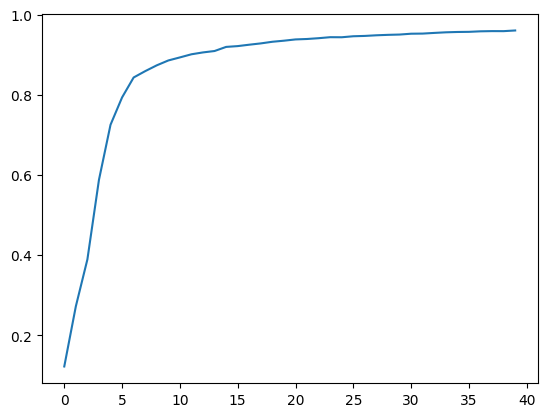

In [ ]:
accuracy_values = [d['accuracy'] for d in Agregation_history]
plt.plot(accuracy_values)
plt.show()

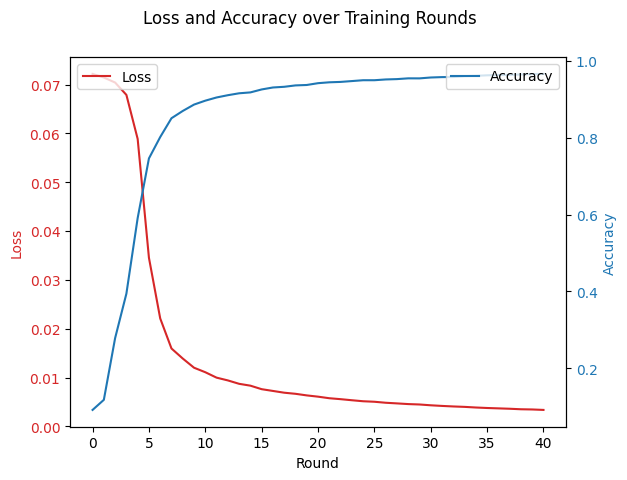

In [ ]:
rounds = [entry["round"] for entry in evaluation_history]
loss = [entry["loss"] for entry in evaluation_history]
accuracy = [entry["accuracy"] for entry in evaluation_history]

fig, ax1 = plt.subplots()

# Plot loss on the first y-axis
ax1.set_xlabel("Round")
ax1.set_ylabel("Loss", color="tab:red")
ax1.plot(rounds, loss, color="tab:red", label="Loss")
ax1.tick_params(axis="y", labelcolor="tab:red")

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color="tab:blue")
ax2.plot(rounds, accuracy, color="tab:blue", label="Accuracy")
ax2.tick_params(axis="y", labelcolor="tab:blue")

# Title and legend
fig.suptitle("Loss and Accuracy over Training Rounds")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Show the plot
plt.show()
